**Pedro Luiz da Costa** - 
**Rafael Libertini** - 
**Gabriel Zezze**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast as ast
import json

In [14]:
airplane = pd.read_csv('airplane.csv')
#airplane = airplane[airplane.recognized]
airplane['timestamp'] = pd.to_datetime(airplane.timestamp)
#airplane = airplane.sort_values(by='timestamp', ascending=False)[-100:]
airplane['drawing'] = airplane['drawing'].apply(json.loads)
airplane.head()
airplane2=airplane.iloc[:3,:]
airplane#.head()

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[167, 109, 80, 69, 58, 31, 57, 117, 99, 52, ...",5152802093400064,True,2017-03-08 21:12:07.266040,airplane
1,CA,"[[[2, 14, 34, 126], [57, 45, 38, 47]], [[41, 4...",6622904974311424,False,2017-03-06 21:39:04.690130,airplane
2,US,"[[[90, 88, 95, 104, 112, 122], [65, 31, 12, 0,...",6577010312740864,True,2017-03-23 02:08:35.229980,airplane
3,US,"[[[82, 49, 15, 4, 0, 5, 30, 85, 89, 93, 112, 1...",5643224746033152,True,2017-03-10 00:35:17.531970,airplane
4,IL,"[[[64, 38, 23, 8, 0, 6, 26, 68], [74, 77, 84, ...",6670046841536512,True,2017-01-23 18:11:11.658170,airplane
5,US,"[[[195, 164, 127, 40, 13, 0, 4, 28, 93, 172, 2...",5509429904539648,True,2017-03-02 19:06:55.494650,airplane
6,CZ,"[[[105, 102, 106, 112, 126, 133, 137, 139, 209...",4885112569200640,True,2017-03-27 19:32:38.753680,airplane
7,AU,"[[[93, 68, 17, 0, 3, 13, 38, 66, 109, 114, 153...",5445677096108032,True,2017-03-29 09:25:50.212600,airplane
8,MY,"[[[1, 2, 8, 17, 22, 28, 94, 99, 99, 102, 105, ...",6687207765049344,True,2017-03-25 10:17:56.501990,airplane
9,BR,"[[[2, 34, 48, 102, 191], [20, 38, 42, 46, 44]]...",5838857872343040,True,2017-03-15 23:26:35.328150,airplane


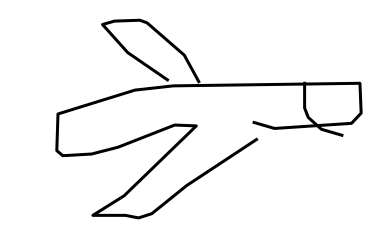

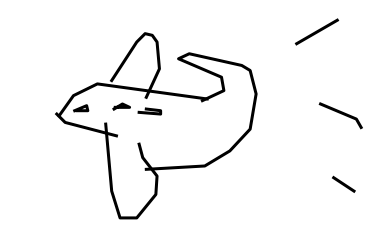

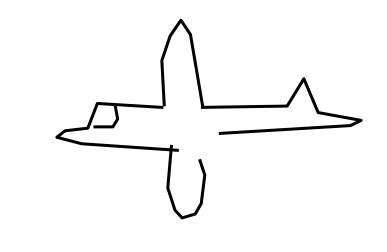

In [19]:
for i, drawing in enumerate(airplane2.drawing):
    for x,y in drawing:
        plt.plot(x, -np.array(y), lw=3, color='black')
        plt.axis('off')
    plt.savefig('avioes/airplane{}.png'.format(i), dpi=10)
    plt.show();